# Выявление особенностей словоупотребления в текстах Л. Н. Толстого методами дистрибутивной семантики

** TO DO **

- обучить сегментатор поточнее

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re

In [3]:
from lxml import etree
from pymystem3 import Mystem
import string
import nltk
from datetime import datetime
mystem = Mystem()

In [3]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [4]:
from numpy import nan
import numpy as np
import pandas as pd
from random import sample
from sklearn.metrics import accuracy_score

In [5]:
from scipy.stats import kendalltau, spearmanr,pearsonr

In [6]:
import gensim

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline  

## Сегментатор

При запуске довольно длинный вывод, поэтому он скрыт

In [ ]:
language_punkt_vars = nltk.tokenize.punkt.PunktLanguageVars
language_punkt_vars.sent_end_chars=('.','?','!','»','…')
with open('.\\data\\traindata.txt', 'r', encoding='utf-8') as f:
    traindata = f.read()
trainer = nltk.tokenize.punkt.PunktTrainer(traindata, language_punkt_vars)
trainer.INCLUDE_ALL_COLLOCS = True 
trainer.INCLUDE_ABBREV_COLLOCS = True
params = trainer.get_params()
sbd = nltk.tokenize.punkt.PunktSentenceTokenizer(params)

## Данные

На основе 90-томного собрания сочинений

Namespace тегов

In [6]:
tei_ns = {'tei': 'http://www.tei-c.org/ns/1.0'}

Знаки пунктуации для удаления

In [7]:
string.punctuation = string.punctuation.replace('-','')
string.punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

## Функции предобработки

#### Функция для парсинга одного файла.

- ** Вход : ** имя файла
- ** Дополлнительные сведения : ** теги для удаления и исключения, пространство имен тегов получает из пространства имен (области видимости) выше по уровню
- ** Выход : ** нужный текст

In [8]:
def get_one_writing(filename):
    global tei_ns
    root = etree.parse(filename)#.getroot()
    for i in tags_for_deletion:
        for j in root.findall(i, tei_ns):
            parent = j.find("..")
            parent.remove(j)
    for i in tags_to_strip:
        etree.strip_tags(root, i)
    return root.find(".//tei:text", tei_ns).text.strip()

#### Функция для препроцессинга текста

- ** Вход : ** текст, файл записи
- ** Дополнительная информация : ** сегментатор, Mystem - глобальные переменные
- ** Выход : ** количество предложений (для вывода и отслеживания)


** Ход преобразований **

1. Исключение множественных пробелов и переносов строки
2. Деление на предложения
3. Объединение с разделителем в виде $$, так как mystem быстрее работает при одном вызове на большой файл, чем на маленьких частях. И такой знак не встречается в текстах
4. Удаляем [], в которых в текстах восстановлены сокращения
5. Лемматизируем с помощью mystem
6. Удаляем некириллические символы (удаляем нерусский текст, знаки препинания (кроме дефисов), оставляем наши разделители
7. Удаялем возможные множественные дефисы
8. Удаляем остатки от слов типа 8-го (-го).
9. Восстанавливаем разбиение на предложения
10. Если от строки осталось более 25 символов (удаляем слишком маленькие предложения и строки, которые у нас отделяются со ссылками типа (Лука, VII), то записываемв файл.

In [9]:
def preprocessing(text, f):
    global sbd, mystem
    text = re.sub('[\n\s]+',' ', text)
    lng = len(sbd.sentences_from_text(text, realign_boundaries=True))
    text = ' $$ '.join(sbd.sentences_from_text(text, realign_boundaries=True))
    text = text.replace('[','').replace(']','')
    text = ''.join(mystem.lemmatize(text.strip()))
    text = re.sub('[^а-яА-Я\-$ ]','', text)
    text = re.sub('[-]{2,}','', text)
    text = re.sub('[^а-яА-Я]-.*? ',' ', text)
    text = text.split('$$')
    for i in text:
        if len(i.strip())>25:
            f.write(i.strip()+'\n')
    return lng

In [10]:
with open ('1.txt', 'w') as f:
    preprocessing ('Я 1-го числа никак не приду к вам.\n\nЗасим удаляюсь.', f)

#### Функция объединяющая преобразования

- ** Вход : ** путь к папке с данными, тэги для удаления, теги для опущения, имя файла записи, параметр печати логов

** Печать **

- если установлен флажок печати, то печатает: количество предложений в тексте, размер файла (для проверки), время обработки файла, имя файла
- общее время работы

In [11]:
def universal_preprocessing(path, 
                            tags_for_deletion, 
                            tags_to_strip, 
                            filename, printing=True):
    #tags_for_deletion = tags_for_deletion
    #tags_to_strip = tags_to_strip
    #mystem = Mystem()
    start_gen = datetime.now()
    with open (filename, 'w', encoding='utf-8') as f:
        for root, dirs, files in os.walk (path):
                for fl in files :
                    start = datetime.now() 
                    lng = preprocessing(get_one_writing(root+'\\'+fl), f)
                    if printing:
                        print ('{}\t{}\t{}\t{}'.format(lng, os.path.getsize(root+'\\'+fl)//1024, 
                                              datetime.now()-start,
                                              fl))
    print ('\n\ntotal time:\t\t {}'.format(datetime.now()-start_gen))
    

### Произведения

Удаляем ненужные комментарии (заметки, пояснения, старые формы, где есть исправления, элементы таблицы). Убираем теги, которые не несут информации, чтобы объединить в единый массив текста.

In [12]:
tags_for_deletion  = ['.//tei:note','.//tei:add','.//tei:sic','.//tei:orig',
                      './/tei:head','.//tei:del','.//tei:figure','.//tei:table']

tags_to_strip = ['{http://www.tei-c.org/ns/1.0}pb', '{http://www.tei-c.org/ns/1.0}hi', '{http://www.tei-c.org/ns/1.0}corr',
                '{http://www.tei-c.org/ns/1.0}reg', '{http://www.tei-c.org/ns/1.0}choice', '{http://www.tei-c.org/ns/1.0}p',
                '{http://www.tei-c.org/ns/1.0}div', '{http://www.tei-c.org/ns/1.0}lb']

НЕ ЗАПУСКАТЬ!!!

In [13]:
path = '.\\data\\Final\\'
universal_preprocessing(path, tags_for_deletion, tags_to_strip, 'writings.txt')

938	125	0:00:02.182899	Abrégé de l’Evangile 24.xml
21	8	0:00:01.690339	AMOUR DE LA PATRIE 1.xml
70	37	0:00:01.979403	Carthago delenda est 39.xml
87	32	0:00:01.801238	Carthago delenda est. Черновое 39.xml
322	95	0:00:02.451469	Letter to a Hindoo (Письмо к индусу) 37.xml
44	13	0:00:01.980461	NOTES SUR LE SECOND CHAPITRE DES «CARACTÈRES» DE LA BRUYÈRE 1.xml
28	13	0:00:02.084049	The hostelry (Гостиница) 37.xml
19	19	0:00:02.041133	[Carthago delenda est] («Жизнь, та форма жизни»...) 27.xml
9	5	0:00:01.725240	[LE PRÉSENT, LE PASSÉ ET LE FUTUR] 1.xml
9	9	0:00:01.620498	[«Давно позабыл я о счастьи ...»] 1.xml
49	29	0:00:01.531272	[«Дядинька Жданов и кавалер Чернов»] 3.xml
60	42	0:00:01.624674	[«Ежели бы человек не желал…»] 1.xml
18	12	0:00:01.594855	[«Ей, Марьяна, брось работу!..»] 1.xml
37	22	0:00:01.562201	[«Знание музыки - субъективное и объективное...»] 1.xml
728	330	0:00:02.259206	[«Начала» романа «Сто лет»] 17.xml
370	203	0:00:02.007993	[«Начала» романа времен Петра I. Азовские походы] 1

### Письма

Добавляются теги <opener> и <closer> как элементы письма, которые не относятся к непосредственному текксту.

In [16]:
tags_for_deletion  = ['.//tei:note','.//tei:add','.//tei:sic','.//tei:orig',
                      './/tei:head','.//tei:del','.//tei:figure','.//tei:table',
                      './/tei:opener', './/tei:closer']

tags_to_strip = ['{http://www.tei-c.org/ns/1.0}pb', '{http://www.tei-c.org/ns/1.0}hi', '{http://www.tei-c.org/ns/1.0}corr',
                '{http://www.tei-c.org/ns/1.0}reg', '{http://www.tei-c.org/ns/1.0}choice', '{http://www.tei-c.org/ns/1.0}p',
                '{http://www.tei-c.org/ns/1.0}div', '{http://www.tei-c.org/ns/1.0}lb','{http://www.tei-c.org/ns/1.0}body']

In [17]:
path = '.\\data\\LETTERS\\'
for root, dirs, files in os.walk (path):
    for fl in files :
        with open (root+'\\'+fl, 'r', encoding='utf-8') as f:
            s = f.read()
            s = re.sub('<note.*?>', '<note>', s)
            s = re.sub('xml:id=".*?"','',s)
        with open (root+'\\'+fl,'w', encoding='utf-8') as f:
            f.write(s)

In [18]:
path = '.\\data\\LETTERS\\'
universal_preprocessing(path, tags_for_deletion, tags_to_strip, 'letters.txt', printing=False)



total time:		 3:40:50.729214


### Дневники

In [14]:
tags_for_deletion  = ['.//tei:note','.//tei:add','.//tei:sic','.//tei:orig',
                      './/tei:head','.//tei:del','.//tei:figure','.//tei:table', './/tei:opener']

tags_to_strip = ['{http://www.tei-c.org/ns/1.0}pb', '{http://www.tei-c.org/ns/1.0}hi', '{http://www.tei-c.org/ns/1.0}corr',
                '{http://www.tei-c.org/ns/1.0}reg', '{http://www.tei-c.org/ns/1.0}choice', '{http://www.tei-c.org/ns/1.0}p',
                '{http://www.tei-c.org/ns/1.0}div', '{http://www.tei-c.org/ns/1.0}lb','{http://www.tei-c.org/ns/1.0}body']

In [15]:
path = '.\\data\\diaries\\'
universal_preprocessing(path, tags_for_deletion, tags_to_strip, 'diaries.txt')

845	981	0:00:02.302519	46.xml
522	698	0:00:02.069947	47.xml
2673	268	0:00:02.784657	48.xml
4699	425	0:00:03.677143	49.xml
6190	778	0:00:05.672677	50.xml
3502	441	0:00:03.856642	51.xml
3827	612	0:00:04.726578	52.xml
4718	897	0:00:06.313160	53.xml
1582	752	0:00:03.274821	54.xml
2210	1117	0:00:03.734177	55.xml
2574	639	0:00:03.960775	56.xml
2833	733	0:00:03.887149	57.xml
2451	568	0:00:02.797811	58.xml


total time:		 0:00:49.060039


## Соединить источники

In [19]:
files = ['writings.txt', 'letters.txt', 'diaries.txt']
with open ('full_collection.txt', 'w',encoding = 'utf-8') as outp:
    for file in files:
        with open (file, 'r', encoding = 'utf-8') as inp:
            for line in inp:
                outp.write(line)

## Референтный корпус

In [23]:
path = '.\\data\\nkrya\\'
start_gen = datetime.now()
with open ('nkrya.txt', 'w', encoding='utf-8') as f:
    for root, dirs, files in os.walk (path):
        for fl in files :
            with open (root+'\\'+fl, 'r', encoding='utf-8') as inp:
                text = re.sub('\{.*?\}','', inp.read())
                lng = preprocessing(text, f)
print ('\n\ntotal time:\t\t {}'.format(datetime.now()-start_gen))



total time:		 3:03:55.088993


## Все модели

Так как данные имеют большой размер, подаем на вход объект, считываемыц из файла (с возможностью итерации без хранения в памяти)

In [2]:
sentences_tolstoy = gensim.models.word2vec.LineSentence('full_collection.txt')
sentences_nkrya = gensim.models.word2vec.LineSentence('nkrya.txt')

### Word2Vec

** CBOW **

In [4]:
Tolstoy_W2V_CBOW = gensim.models.Word2Vec(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
Tolstoy_W2V_CBOW.save("./models/Tolstoy_W2V_CBOW.model")
print(Tolstoy_W2V_CBOW)

Word2Vec(vocab=33439, size=300, alpha=0.025)


In [5]:
NKRYA_W2V_CBOW = gensim.models.Word2Vec(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
NKRYA_W2V_CBOW.save("./models/NKRYA_W2V_CBOW.model")
print(NKRYA_W2V_CBOW)

Word2Vec(vocab=55217, size=300, alpha=0.025)


** Skipgram **

In [6]:
Tolstoy_W2V_SG = gensim.models.Word2Vec(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
Tolstoy_W2V_SG.save("./models/Tolstoy_W2V_SG.model")
print(Tolstoy_W2V_SG)

Word2Vec(vocab=33439, size=300, alpha=0.025)


In [9]:
NKRYA_W2V_SG = gensim.models.Word2Vec(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
NKRYA_W2V_SG.save("./models/NKRYA_W2V_SG.model")
print(NKRYA_W2V_SG)

Word2Vec(vocab=55217, size=300, alpha=0.025)


### FastText

** CBOW **

In [10]:
Tolstoy_FT_CBOW = gensim.models.fasttext.FastText(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
Tolstoy_FT_CBOW.save("./models/Tolstoy_FT_CBOW.model")
print(Tolstoy_FT_CBOW)

FastText(vocab=33439, size=300, alpha=0.025)


In [3]:
NKRYA_FT_CBOW = gensim.models.fasttext.FastText(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=0, 
                                            seed=23) #CBOW
NKRYA_FT_CBOW.save("./models/NKRYA_FT_CBOW.model")
print(NKRYA_FT_CBOW)

FastText(vocab=55217, size=300, alpha=0.025)


** Skipgram **

In [12]:
Tolstoy_FT_SG = gensim.models.fasttext.FastText(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
Tolstoy_FT_SG.save("./models/Tolstoy_FT_SG.model")
print(Tolstoy_FT_SG)

FastText(vocab=33439, size=300, alpha=0.025)


In [13]:
NKRYA_FT_SG = gensim.models.fasttext.FastText(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
NKRYA_FT_SG.save("./models/NKRYA_FT_SG.model")
print(NKRYA_FT_SG)

FastText(vocab=55217, size=300, alpha=0.025)


** Загрузка всех моделей **

In [11]:
Tolstoy_W2V_CBOW = gensim.models.Word2Vec.load("./models/Tolstoy_W2V_CBOW.model")
NKRYA_W2V_CBOW = gensim.models.Word2Vec.load("./models/NKRYA_W2V_CBOW.model")
Tolstoy_W2V_SG = gensim.models.Word2Vec.load("./models/Tolstoy_W2V_SG.model")
NKRYA_W2V_SG = gensim.models.Word2Vec.load("./models/NKRYA_W2V_SG.model")

In [17]:
Tolstoy_FT_CBOW = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_CBOW.model")
NKRYA_FT_CBOW = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_CBOW.model")
Tolstoy_FT_SG = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_SG.model")
NKRYA_FT_SG = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_SG.model")

In [12]:
Araneum_FT_CBOW = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextcbow_300_5_2018.model")
Araneum_FT_SG = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextskipgram_300_5_2018.model")

## Сравнение

### Simlex

In [5]:
simlex = pd.read_csv('./data/ru_simlex965.tsv', sep='\t')

In [6]:
simlex.columns = ['Word1','Word2','Score_SL']
simlex['Score_SL'].dtype

dtype('float64')

In [7]:
a = list(simlex['Word1'])
b = list(simlex['Word2'])
simlex_words = list(zip(a,b))

In [8]:
def model_result(words,model):
    try:
        result =  model.wv.similarity(words[0], words[1])
        return result
    except:
        return nan

In [ ]:
models = [Tolstoy_W2V_CBOW, NKRYA_W2V_CBOW, Tolstoy_W2V_SG, NKRYA_W2V_SG,
          Tolstoy_FT_CBOW, NKRYA_FT_CBOW, Tolstoy_FT_SG, NKRYA_FT_SG,
          Araneum_FT_CBOW, Araneum_FT_SG]
model_names = ['Tolstoy_W2V_CBOW', 'NKRYA_W2V_CBOW', 'Tolstoy_W2V_SG', 'NKRYA_W2V_SG',
          'Tolstoy_FT_CBOW', 'NKRYA_FT_CBOW', 'Tolstoy_FT_SG', 'NKRYA_FT_SG',
          'Araneum_FT_CBOW', 'Araneum_FT_SG']
all_models = list(zip(models,model_names))

In [13]:
for i in all_models:
    simlex[i[1]] = np.apply_along_axis(model_result, 1, arr = simlex_words, model = i[0] )

In [14]:
simlex.head()

,Word1,Word2,Score_SL,Tolstoy_W2V_CBOW,NKRYA_W2V_CBOW,Tolstoy_W2V_SG,NKRYA_W2V_SG,Tolstoy_FT_CBOW,NKRYA_FT_CBOW,Tolstoy_FT_SG,NKRYA_FT_SG,Araneum_FT_CBOW,Araneum_FT_SG
0,авария,бедствие,6.15,0.315040,0.312024,0.458422,0.383732,0.366403,0.401920,0.387836,0.423720,0.417583,0.532138
1,август,месяц,2.85,0.517988,0.390630,0.473710,0.403803,0.552756,0.394618,0.513207,0.400371,0.365336,0.538927
2,авиация,полет,6.77,NaN,NaN,NaN,NaN,0.315683,0.418777,0.336305,0.353902,0.369196,0.480803
3,автомобиль,гудок,1.85,NaN,NaN,NaN,NaN,0.309600,0.287628,0.541232,0.209126,0.052265,0.259283
4,автомобиль,автострада,1.23,NaN,NaN,NaN,NaN,0.287549,0.612199,0.642494,0.515194,0.521806,0.449036


In [15]:
simlex_short = simlex.dropna()

In [17]:
for i in all_models:
    print ('{}\t\t{}'.format(i[1], spearmanr(simlex_short[i[1]], simlex_short['Score_SL'])[0]))

Tolstoy_W2V_CBOW		-0.02312097810078662
NKRYA_W2V_CBOW		0.2728283340461548
Tolstoy_W2V_SG		0.13547678929311274
NKRYA_W2V_SG		0.3180245293198616
Tolstoy_FT_CBOW		0.10480719946239418
NKRYA_FT_CBOW		0.24098530695427278
Tolstoy_FT_SG		0.15588363327276267
NKRYA_FT_SG		0.27768484342806704
Araneum_FT_CBOW		0.3220139240500222
Araneum_FT_SG		0.3263901137902892


** Пропорции **

** семья **

In [18]:
family = pd.read_csv('./data/ru_analogy_family.txt', sep=' ', header=None)
family.columns = ['Word1','Word2','Word3','Result']

In [20]:
a = list(family['Word1'])
b = list(family['Word2'])
c = list(family['Word3'])
family_words = list(zip(a,b,c))

In [21]:
def proportion(words,model):
    #print (words)
    try:
        result = model.wv.most_similar(positive=[words[0], words[1]], negative=[words[2]])[0][0]
        return result
    except:
        return nan

In [22]:
for i in all_models:
    family[i[1]] = [proportion(words, i[0]) for words in family_words]

In [25]:
family.head(5)

,Word1,Word2,Word3,Result,Tolstoy_W2V_CBOW,NKRYA_W2V_CBOW,Tolstoy_W2V_SG,NKRYA_W2V_SG,Tolstoy_FT_CBOW,NKRYA_FT_CBOW,Tolstoy_FT_SG,NKRYA_FT_SG,Araneum_FT_CBOW,Araneum_FT_SG
0,мальчик,девочка,брат,сестра,кукла,мальчуган,девушка,девушка,девчонка,мальчишечка,кмальчик,девочка-подросток,пай-девочка,девчушка
1,мальчик,девочка,братья,сестры,девушка,мальчуган,девушка,мальчуган,кмальчик,мальчишечка,кмальчик,девочка-подросток,мальчонка,малышка
2,мальчик,девочка,папа,мама,юноша,мальчуган,двойня,мальчуган,мальчик-сын,мальчонка,кмальчик,девочка-подросток,мальчонка,девчушка
3,мальчик,девочка,отец,мать,баба,мальчуган,девушка,мальчуган,девчонка,мальчишечка,кмальчик,мальчишечка,пай-девочка,девчушка
4,мальчик,девочка,дед,бабка,девушка,мальчуган,девушка,девушка,мальчишка,мальчишечка,кмальчик,мальчишечка,пай-девочка,малышка


In [30]:
for i in all_models:
    print (i[1], '\t', accuracy_score(list(family['Result']),list(family[i[1]])))

Tolstoy_W2V_CBOW 	 0.0
NKRYA_W2V_CBOW 	 0.003952569169960474
Tolstoy_W2V_SG 	 0.0
NKRYA_W2V_SG 	 0.005928853754940711
Tolstoy_FT_CBOW 	 0.0
NKRYA_FT_CBOW 	 0.0
Tolstoy_FT_SG 	 0.0
NKRYA_FT_SG 	 0.0
Araneum_FT_CBOW 	 0.0
Araneum_FT_SG 	 0.0


** Прилагательные/наречия **

In [31]:
adj_adv = pd.read_csv('./data/ru_analogy_adj-adv.txt', sep=' ', header=None)
adj_adv.columns = ['Word1','Word2','Word3','Result']

In [32]:
a = list(adj_adv['Word1'])
b = list(adj_adv['Word2'])
c = list(adj_adv['Word3'])
adj_adv_words = list(zip(a,b,c))

In [33]:
for i in all_models:
    adj_adv[i[1]] = [proportion(words, i[0]) for words in adj_adv_words]

In [34]:
adj_adv.head(5)

,Word1,Word2,Word3,Result,Tolstoy_W2V_CBOW,NKRYA_W2V_CBOW,Tolstoy_W2V_SG,NKRYA_W2V_SG,Tolstoy_FT_CBOW,NKRYA_FT_CBOW,Tolstoy_FT_SG,NKRYA_FT_SG,Araneum_FT_CBOW,Araneum_FT_SG
0,удивительный,удивительно,очевидный,очевидно,ах,чудно,прелестный,прелестно,презрительно,неудивительный,неудивительный,неудивительный,необыкновенно,необыкновенно
1,удивительный,удивительно,спокойный,спокойно,глупо,замечательный,неважно,замечательный,значительно,неудивительный,неудивительный,неудивительный,поразительно,поразительный
2,удивительный,удивительно,веселый,весело,доказываться,поразительный,гадание,изумительный,неосновательно,неудивительный,неудивительный,неудивительный,поразительный,поразительный
3,удивительный,удивительно,страшный,страшно,умно,замечательно,умно,замечательно,одобрительно,замечательно,неудивительный,неудивительный,необычайно,необыкновенно
4,удивительный,удивительно,эффективный,эффективно,NaN,NaN,NaN,NaN,неудивительный,неудивительный,неудивительный,неудивительный,необыкновенно,необыкновенный


In [41]:
for i in all_models:
    print (i[1], '\t', accuracy_score(list(adj_adv['Result']),list(adj_adv[i[1]])))

Tolstoy_W2V_CBOW 	 0.00221606648199446
NKRYA_W2V_CBOW 	 0.000554016620498615
Tolstoy_W2V_SG 	 0.00110803324099723
NKRYA_W2V_SG 	 0.000554016620498615
Tolstoy_FT_CBOW 	 0.000554016620498615
NKRYA_FT_CBOW 	 0.000554016620498615
Tolstoy_FT_SG 	 0.000554016620498615
NKRYA_FT_SG 	 0.00110803324099723
Araneum_FT_CBOW 	 0.000554016620498615
Araneum_FT_SG 	 0.0016620498614958448


## Первый способ : искуственные сдвиги

Для оценки того, что является сдвигом, нужно создать его контролируемо и посмотреть на то, как он будет выглядеть. Нужно определить, какая метрика лучше отражает сдвиг, то есть будет коррелировать с тем, в какой степени мы изменили значение. Для этого заменим часть слов на сходные по частоте.

In [5]:
freq = pd.read_csv('./data/freqrnc2011.csv', sep='\t')

In [6]:
freq.columns = ['Lemma','PoS','Freq','R','D','Doc']

In [7]:
freq.head()

,Lemma,PoS,Freq,R,D,Doc
0,а,conj,8198.0,100,97,32332
1,а,intj,19.8,99,90,757
2,а,part,6.1,59,79,128
3,а,s,2.7,59,85,160
4,аа,intj,1.5,47,80,68


In [8]:
freq.shape

(52138, 6)

In [10]:
freq = freq[(freq.Freq > 100) & (freq.Freq < 1000)]
freq.shape

(1145, 6)

In [11]:
freq.head()

,Lemma,PoS,Freq,R,D,Doc
192,автомобиль,s,156.9,100,92,3453
207,автор,s,262.1,100,93,6216
462,акт,s,113.6,99,84,2830
465,актер,s,114.4,99,87,1827
533,Александр,s.PROP,237.8,100,91,6592


In [12]:
Tolstoy_W2V_CBOW = gensim.models.Word2Vec.load("./models/Tolstoy_W2V_CBOW.model")
NKRYA_W2V_CBOW = gensim.models.Word2Vec.load("./models/NKRYA_W2V_CBOW.model")
Araneum_FT_CBOW = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextcbow_300_5_2018.model")

In [13]:
vocab = list(set(Tolstoy_W2V_CBOW.wv.vocab) & set(NKRYA_W2V_CBOW.wv.vocab) & set(Araneum_FT_CBOW.wv.vocab) & set(freq['Lemma']))

In [14]:
len(vocab)

934

In [16]:
word_list = sample(vocab, 600)

In [17]:
list(reversed([1,2,3]))

[3, 2, 1]

In [18]:
Artificial_shifts =pd.DataFrame({
    'Lemma':word_list,
    'Lemma2':list(reversed(word_list[:200]))+list(reversed(word_list[200:400]))+list(reversed(word_list[400:600])), 
    'Q':[0.9]*200+[0.7]*200+[0.5]*200})

In [19]:
Artificial_shifts.head()

,Lemma,Lemma2,Q
0,нога,подходить,0.9
1,страх,тело,0.9
2,хозяин,против,0.9
3,ставить,использовать,0.9
4,нормальный,голос,0.9


In [20]:
Artificial_shifts.to_csv('./data/art_shifts.csv', sep='\t', index=False, encoding='utf-8')

Загружаем

In [31]:
Artificial_shifts = pd.read_csv('./data/art_shifts.csv', sep='\t', encoding='utf-8')

In [32]:
Artificial_shifts = Artificial_shifts.set_index('Lemma')

In [38]:
Artificial_shifts['target'] = Artificial_shifts['Q']*10

Artificial_shifts['T_counter'] = [0]*600
Artificial_shifts['T_changed'] = [0]*600
Artificial_shifts['T_total'] = [0]*600

Artificial_shifts['19_counter'] = [0]*600
Artificial_shifts['19_changed'] = [0]*600
Artificial_shifts['19_total'] = [0]*600

In [34]:
lemma = set(Artificial_shifts.index)

In [39]:
with open ('full_collection.txt', 'r', encoding = 'utf-8') as inp:
    with open ('full_collection_shift.txt', 'w', encoding = 'utf-8') as outp:
        for line in inp:
            unchanged = line.strip().split()
            changed = []
            for i in unchanged:
                if i in lemma:
                    change = Artificial_shifts['Lemma2'][i]
                    if Artificial_shifts['T_counter'][i] % 10 >= Artificial_shifts['target'][i]:               
                        changed.append(change)
                        Artificial_shifts.set_value(i, 'T_counter', Artificial_shifts['T_counter'][i] + 1)
                        Artificial_shifts.set_value(i, 'T_changed', Artificial_shifts['T_changed'][i] + 1)
                        #if Artificial_shifts['counter'][i] == 10:
                        #    Artificial_shifts.set_value(i, 'counter', 0) 
                    else:
                        changed.append(i)
                        Artificial_shifts.set_value(i, 'T_counter', Artificial_shifts['T_counter'][i] + 1)
                    Artificial_shifts.set_value(i, 'T_total', Artificial_shifts['T_total'][i] + 1)
                else:
                    changed.append(i)
            outp.write(' '.join(changed)+'\n')

In [42]:
Artificial_shifts['T'] = 1 - Artificial_shifts['T_changed']/Artificial_shifts['T_total']

In [44]:
Artificial_shifts[['Q','T']].corr()

,Q,T
Q,1.000000,0.972824
T,0.972824,1.000000


In [45]:
with open ('nkrya.txt', 'r', encoding = 'utf-8') as inp:
    with open ('nkrya_shift.txt', 'w', encoding = 'utf-8') as outp:
        for line in inp:
            unchanged = line.strip().split()
            changed = []
            for i in unchanged:
                if i in lemma:
                    change = Artificial_shifts['Lemma2'][i]
                    if Artificial_shifts['19_counter'][i] % 10 >= Artificial_shifts['target'][i]:               
                        changed.append(change)
                        Artificial_shifts.set_value(i, '19_counter', Artificial_shifts['19_counter'][i] + 1)
                        Artificial_shifts.set_value(i, '19_changed', Artificial_shifts['19_changed'][i] + 1)
                    else:
                        changed.append(i)
                        Artificial_shifts.set_value(i, '19_counter', Artificial_shifts['19_counter'][i] + 1)
                    Artificial_shifts.set_value(i, '19_total', Artificial_shifts['19_total'][i] + 1)
                else:
                    changed.append(i)
            outp.write(' '.join(changed)+'\n')

In [46]:
Artificial_shifts['19'] = 1 - Artificial_shifts['19_changed']/Artificial_shifts['19_total']

In [47]:
Artificial_shifts[['Q','19']].corr()

,Q,19
Q,1.000000,0.999978
19,0.999978,1.000000


In [48]:
Artificial_shifts.to_csv('./data/new_art.csv', sep='\t', index=False, encoding='utf-8')

### Обучим модели и сравним

In [49]:
sentences_tolstoy = gensim.models.word2vec.LineSentence('full_collection_shift.txt')
sentences_nkrya = gensim.models.word2vec.LineSentence('nkrya_shift.txt')

In [50]:
Tolstoy_FT_SG_shift = gensim.models.fasttext.FastText(sentences_tolstoy, 
                                            min_count=2, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
Tolstoy_FT_SG_shift.save("./models/Tolstoy_FT_SG_shift.model")
print(Tolstoy_FT_SG_shift)

FastText(vocab=33439, size=300, alpha=0.025)


In [51]:
NKRYA_FT_SG_shift = gensim.models.fasttext.FastText(sentences_nkrya, 
                                            min_count=10, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
NKRYA_FT_SG_shift.save("./models/NKRYA_FT_SG_shift.model")
print(NKRYA_FT_SG_shift)

FastText(vocab=55217, size=300, alpha=0.025)


In [59]:
Tolstoy_FT_SG = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_SG.model")
NKRYA_FT_SG = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_SG.model")
Tolstoy_FT_SG_shift = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_SG_shift.model")
NKRYA_FT_SG_shift = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_SG_shift.model")

### Метрики

In [13]:
def Kendall(word, model1, model2, topn=50):
    if word in model1.wv.vocab:
        one = model1.wv.most_similar(word, topn = topn)
    else:
        return nan
    a = list(zip(*one))[1]
    words = list(zip(*one))[0]
    b = []
    if word in model2.wv.vocab:
        ref = {value[0]:key for key, value in enumerate(model2.wv.most_similar(word, topn = topn))}
        for i in words:
            if i in ref:
                b.append(ref[i])
            else:
                b.append(topn)
        #a = list(a)
        result = kendalltau(list(range(0, topn)), b)[0]
        return result
    else:
        return nan

In [14]:
def Jaccard(word, model1, model2, topn=50):
    try:
        a = model1.wv.most_similar(word, topn = topn)
        b = model2.wv.most_similar(word, topn = topn)
        a = set(list(zip(*a))[0])
        b = set(list(zip(*b))[0])
        return len(a&b) / len (a | b)
    except:
        return nan

** NDCG **

In [15]:
import math
def find_dcg(element_list):
    """
    Reference : https://github.com/dkaterenchuk/ranking_measures/
    Discounted Cumulative Gain (DCG)
    Parameters:
        element_list - a list of ranks Ex: [5,4,2,2,1]
    """
    score = 0.0
    for order, rank in enumerate(element_list):
        score += float(rank)/math.log((order+2))
    return score


def find_ndcg(reference, hypothesis):
    """
    Reference : https://github.com/dkaterenchuk/ranking_measures/
    Parameters:
        reference   - a gold standard (perfect) ordering Ex: [5,4,3,2,1]
        hypothesis  - a proposed ordering Ex: [5,2,2,3,1]
    Returns:
        ndcg_score  - normalized score
    """

    return find_dcg(hypothesis)/find_dcg(reference)

def get_new_scores(word, model1, model2, topn=50):
    if word in model1.wv.vocab:
        one = model1.wv.most_similar(word, topn = topn)
    else:
        return nan
    a = list(zip(*one))[1]
    words = list(zip(*one))[0]
    b = []
    if word in model2.wv.vocab:
        ref = {value[0]:topn-key for key, value in enumerate(model2.wv.most_similar(word, topn = topn))}
        for i in words:
            if i in ref:
                b.append(ref[i])
            else:
                b.append(0)
        #a = list(a)
        result = find_ndcg(list(range(topn, 0, -1)), b)
        return result
    else:
        return nan

### Check

In [63]:
Artificial_shifts = pd.read_csv('./data/art_shifts.csv', sep='\t', encoding='utf-8')

In [16]:
Kendall_vec = np.vectorize(Kendall)
Jaccard_vec = np.vectorize(Jaccard)
ndcg_vec = np.vectorize(get_new_scores)

In [ ]:
Kendall_vec

In [68]:
Jccrd = []
NDCG = []
x = list(range(10,301,10))
for i in x:
    Jccrd.append(pearsonr(Jaccard_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0])
    NDCG.append(pearsonr(ndcg_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0])

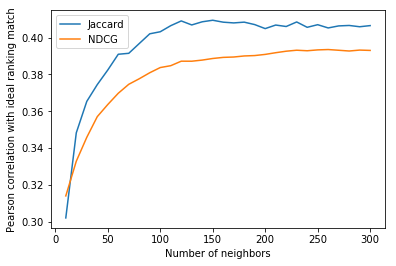

In [70]:
plt.plot(x, Jccrd, label = 'Jaccard')
plt.plot(x, NDCG, label = 'NDCG')
plt.legend(['Jaccard', 'NDCG'])
plt.ylabel('Pearson correlation with ideal ranking match')
plt.xlabel('Number of neighbors')
plt.savefig('Tolstoy_JN.png', dpi=200)
plt.show()

In [71]:
Jccrd = []
NDCG = []
x = list(range(10,301,10))
for i in x:
    Jccrd.append(pearsonr(Jaccard_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0])
    NDCG.append(pearsonr(ndcg_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, i),
             Artificial_shifts['Q'].values)[0])

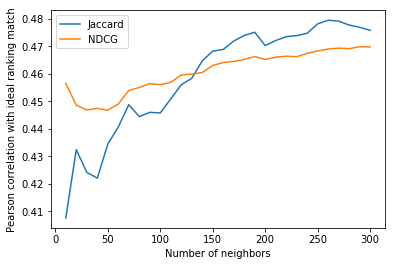

In [76]:
plt.plot(x, Jccrd, label = 'Jaccard')
plt.plot(x, NDCG, label = 'NDCG')
plt.legend(['Jaccard', 'NDCG'])
plt.ylabel('Pearson correlation with ideal ranking match')
plt.xlabel('Number of neighbors')
plt.savefig('19_JN.png', dpi=200)
plt.show()

In [65]:
Artificial_shifts['T_Kendall'] = Kendall_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, 150)
Artificial_shifts['T_Jaccard'] = Jaccard_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, 150)
Artificial_shifts['T_NDCG'] = ndcg_vec(Artificial_shifts['Lemma'].values, Tolstoy_FT_SG, Tolstoy_FT_SG_shift, 150)

Artificial_shifts['19_Kendall'] = Kendall_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, 150)
Artificial_shifts['19_Jaccard'] = Jaccard_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, 150)
Artificial_shifts['19_NDCG'] = ndcg_vec(Artificial_shifts['Lemma'].values, NKRYA_FT_SG, NKRYA_FT_SG_shift, 150)

In [66]:
data = Artificial_shifts[['Q', 'T_Kendall','T_Jaccard','T_NDCG']]
data.corr(method='pearson')

,Q,T_Kendall,T_Jaccard,T_NDCG
Q,1.000000,0.308338,0.409485,0.388679
T_Kendall,0.308338,1.000000,0.857290,0.876627
T_Jaccard,0.409485,0.857290,1.000000,0.959425
T_NDCG,0.388679,0.876627,0.959425,1.000000


In [67]:
data = Artificial_shifts[['Q', '19_Kendall','19_Jaccard','19_NDCG']]
data.corr(method='pearson')

,Q,19_Kendall,19_Jaccard,19_NDCG
Q,1.000000,0.339639,0.468192,0.462985
19_Kendall,0.339639,1.000000,0.849684,0.876704
19_Jaccard,0.468192,0.849684,1.000000,0.961458
19_NDCG,0.462985,0.876704,0.961458,1.000000


In [83]:
Artificial_shifts['T_m'] = Artificial_shifts['T_Jaccard'].values*Artificial_shifts['T_NDCG'].values
Artificial_shifts['19_m'] = Artificial_shifts['19_Jaccard'].values*Artificial_shifts['19_NDCG'].values

In [84]:
data = Artificial_shifts[['Q', 'T_m', '19_m']]
data.corr(method='pearson')

,Q,T_m,19_m
Q,1.000000,0.413379,0.462479
T_m,0.413379,1.000000,0.748915
19_m,0.462479,0.748915,1.000000


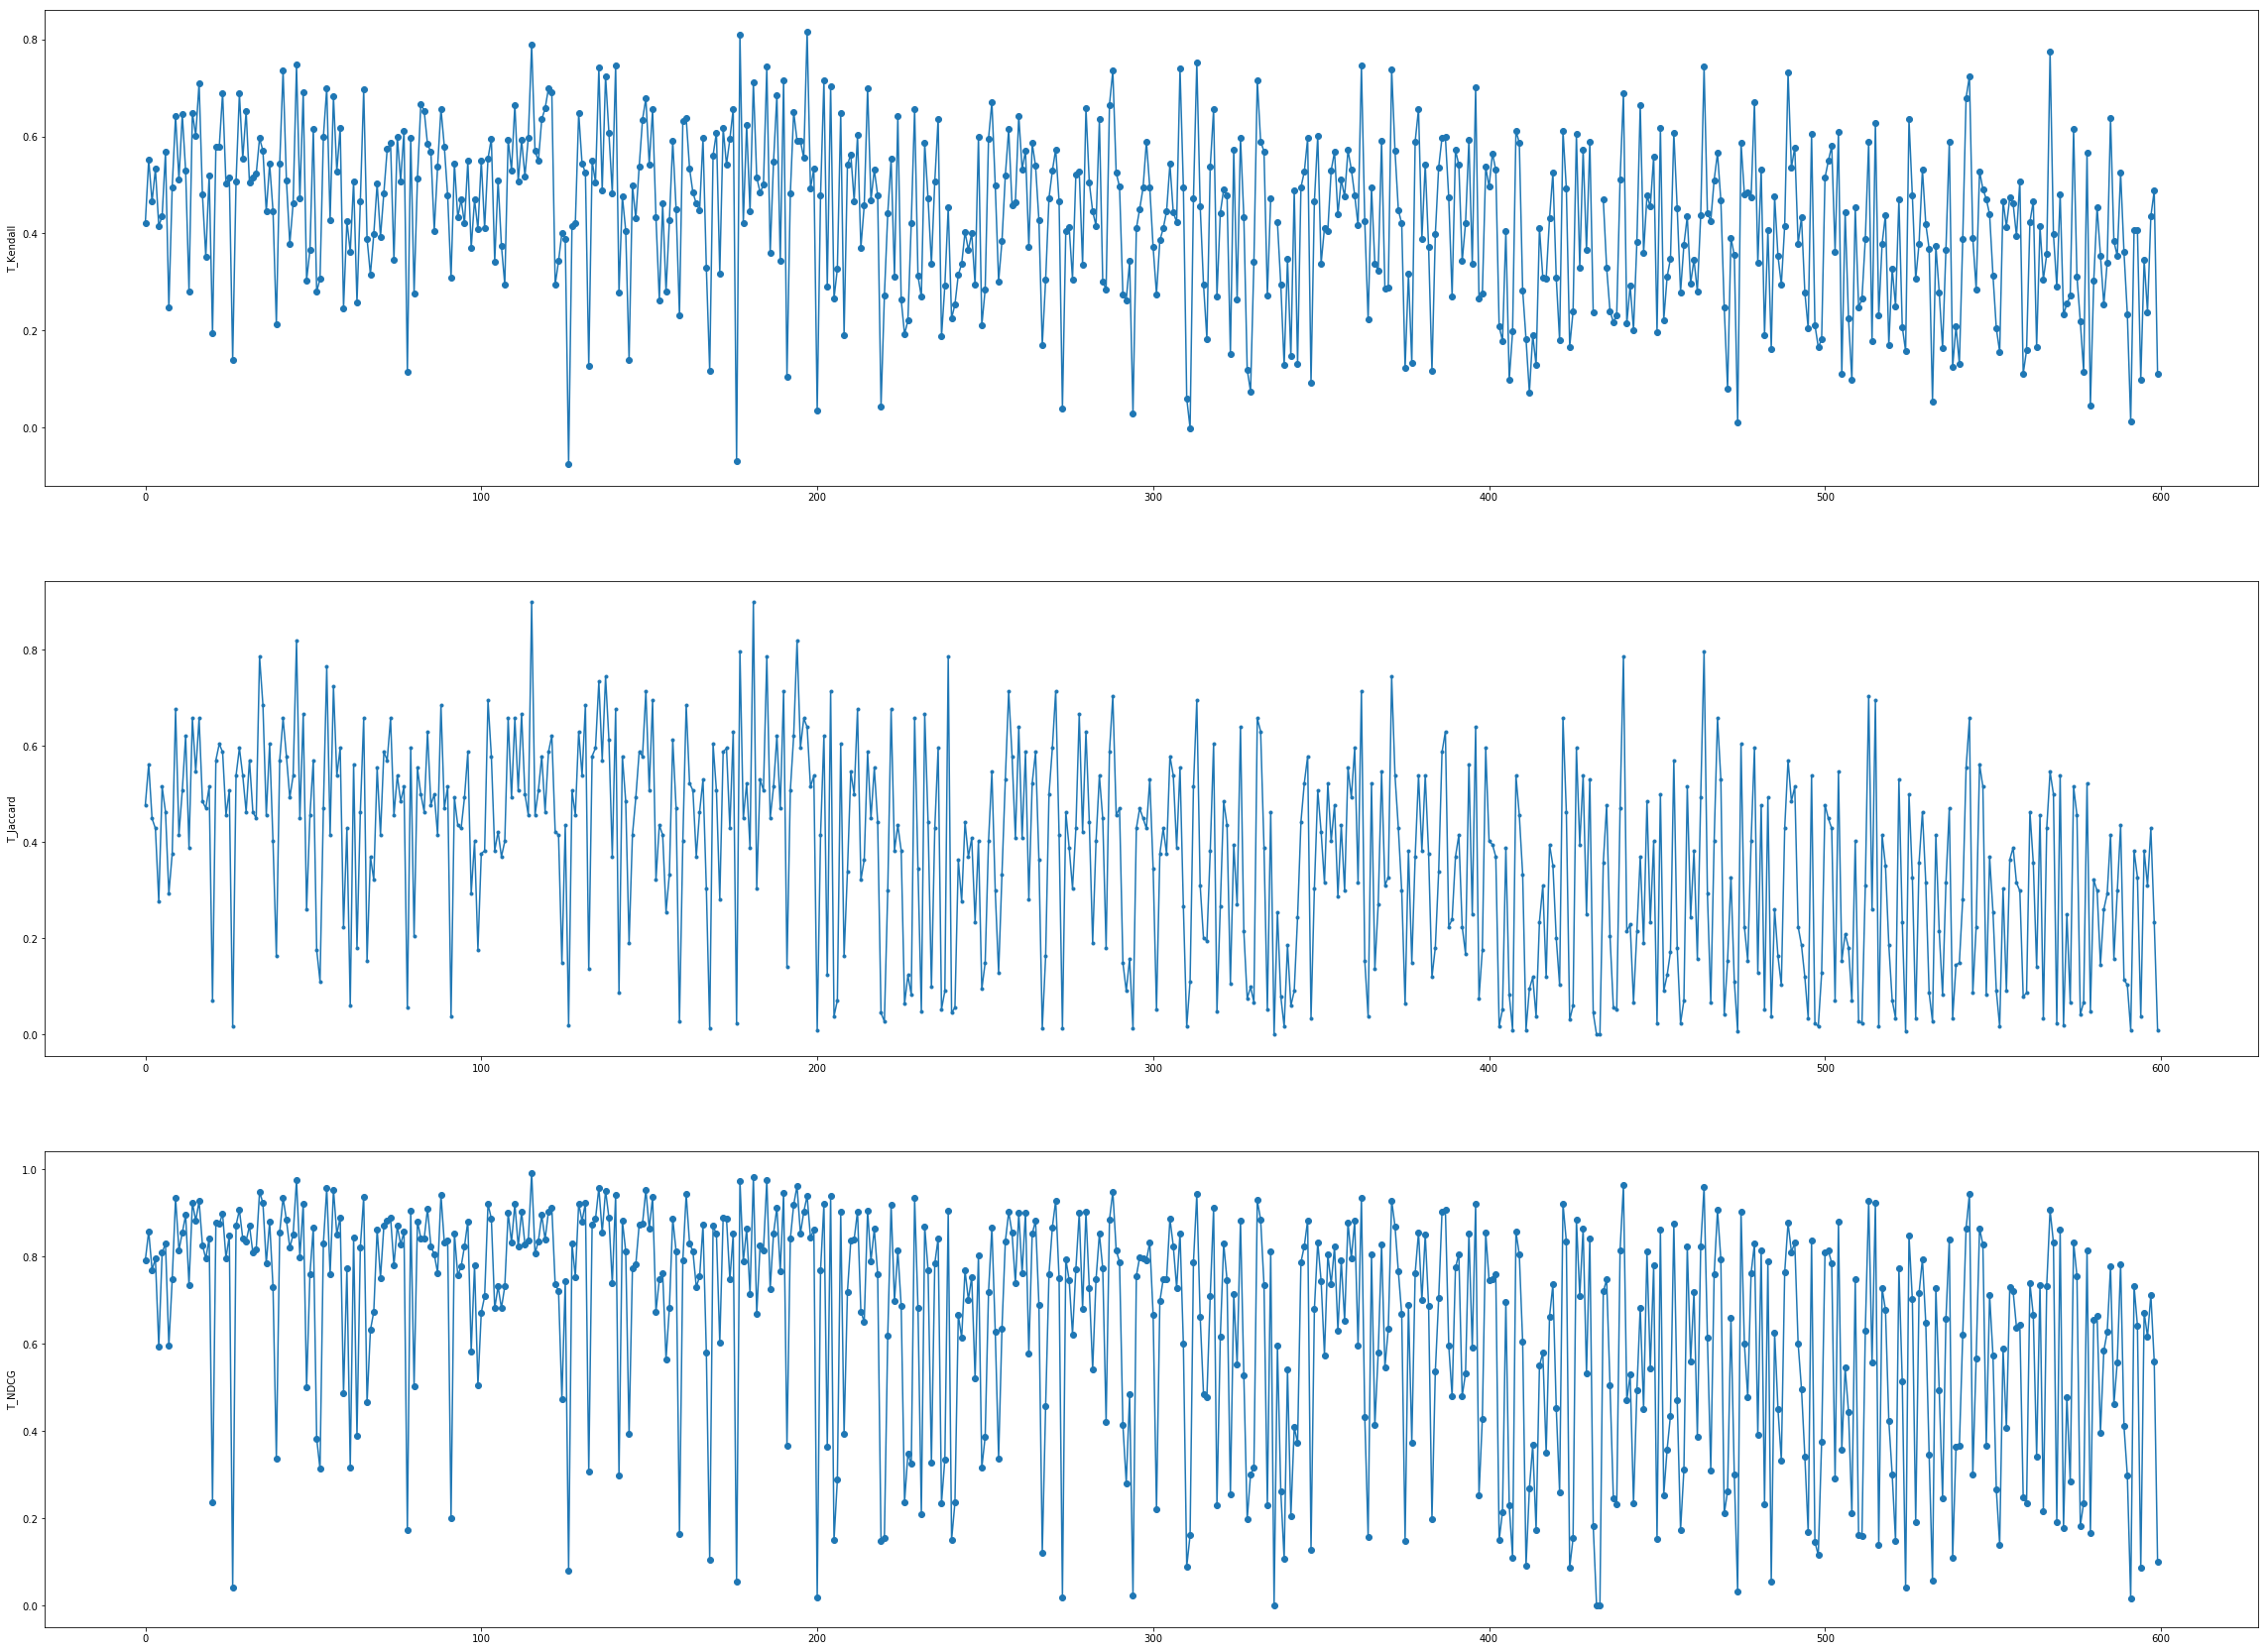

In [85]:
y1 = np.array(Artificial_shifts['T_Kendall'].values)
y2 = np.array(Artificial_shifts['T_Jaccard'].values)
y3 = np.array(Artificial_shifts['T_NDCG'].values)

x = list(range(600))
plt.figure(figsize=(40,30))

plt.subplot(3, 1, 1)
plt.plot(x, y1, 'o-')
#plt.title('A tale of 2 subplots')
plt.ylabel('T_Kendall')

plt.subplot(3, 1, 2)
plt.plot(x, y2, '.-')
#plt.xlabel('time (s)')
plt.ylabel('T_Jaccard')

plt.subplot(3, 1, 3)
plt.plot(x, y3, 'o-')
#plt.title('A tale of 2 subplots')
plt.ylabel('T_NDCG')

plt.show()

In [86]:
Artificial_shifts.head(15)

,Lemma,Lemma2,Q,T_Kendall,T_Jaccard,T_NDCG,19_Kendall,19_Jaccard,19_NDCG,T_m,19_m
0,нога,подходить,0.9,0.421949,0.477833,0.791755,0.510476,0.515152,0.849471,0.378326,0.437606
1,страх,тело,0.9,0.552168,0.562500,0.857699,0.596615,0.538462,0.868000,0.482456,0.467385
2,хозяин,против,0.9,0.465192,0.449275,0.769552,0.409537,0.363636,0.712248,0.345741,0.258999
3,ставить,использовать,0.9,0.532878,0.428571,0.794757,0.676411,0.522843,0.849012,0.340610,0.443900
4,нормальный,голос,0.9,0.414697,0.276596,0.593178,0.292312,0.153846,0.432270,0.164070,0.066503
5,прежде,московский,0.9,0.435730,0.515152,0.808372,0.403966,0.250000,0.522071,0.416434,0.130518
6,американский,бить,0.9,0.567363,0.463415,0.829990,0.577185,0.546392,0.857703,0.384630,0.468642
7,вроде,доход,0.9,0.246785,0.293103,0.595704,0.374020,0.282051,0.607982,0.174603,0.171482
8,вместо,разработка,0.9,0.495529,0.376147,0.746885,0.391281,0.282051,0.607095,0.280938,0.171232
9,оставаться,особенность,0.9,0.642746,0.675978,0.933984,0.570020,0.648352,0.899546,0.631352,0.583222


In [87]:
Artificial_shifts.tail(15)

,Lemma,Lemma2,Q,T_Kendall,T_Jaccard,T_NDCG,19_Kendall,19_Jaccard,19_NDCG,T_m,19_m
585,большой,автор,0.5,0.637560,0.415094,0.776511,0.589385,0.421801,0.762566,0.322325,0.321651
586,считаться,ветер,0.5,0.383587,0.158301,0.460483,0.261937,0.083032,0.278837,0.072895,0.023153
587,оценка,фонд,0.5,0.353947,0.298701,0.557679,0.276858,0.415094,0.731600,0.166580,0.303683
588,государство,бутылка,0.5,0.524700,0.435407,0.782009,0.441710,0.351351,0.642216,0.340492,0.225644
589,квартира,служба,0.5,0.361646,0.115242,0.410907,0.427875,0.260504,0.570803,0.047354,0.148697
590,сначала,разговор,0.5,0.234052,0.102941,0.298136,0.262906,0.071429,0.193672,0.030691,0.013834
591,актер,ночь,0.5,0.012570,0.010101,0.016335,0.076415,0.016949,0.092219,0.000165,0.001563
592,дерево,принцип,0.5,0.406849,0.382488,0.732012,0.534447,0.515152,0.840252,0.279986,0.432857
593,долго,тихий,0.5,0.406312,0.327434,0.642081,0.497522,0.298701,0.657551,0.210239,0.196411
594,кухня,партия,0.5,0.098401,0.038062,0.085704,0.312178,0.127820,0.266287,0.003262,0.034037


In [88]:
from sklearn.linear_model import LinearRegression

In [89]:
AS = Artificial_shifts.dropna()

In [90]:
Y = AS['Q']

In [91]:
lr = LinearRegression()
x_T = AS[['T_Kendall','T_Jaccard','T_NDCG']]
lr.fit(x_T, Y)
AS['T_LR'] = lr.predict(x_T)
lr.coef_ 

array([-0.15418717,  0.38714954,  0.03104644])

In [92]:
lr = LinearRegression()
x_19 = AS[['19_Kendall','19_Jaccard','19_NDCG']]#print(x_T.head())
lr.fit(x_19, Y)
AS['19_LR'] = lr.predict(x_19)
lr.coef_ 

array([-0.29810521,  0.27907758,  0.24922754])

In [93]:
AS.head()

,Lemma,Lemma2,Q,T_Kendall,T_Jaccard,T_NDCG,19_Kendall,19_Jaccard,19_NDCG,T_m,19_m,T_LR,19_LR
0,нога,подходить,0.9,0.421949,0.477833,0.791755,0.510476,0.515152,0.849471,0.378326,0.437606,0.747648,0.771758
1,страх,тело,0.9,0.552168,0.562500,0.857699,0.596615,0.538462,0.868000,0.482456,0.467385,0.762396,0.757203
2,хозяин,против,0.9,0.465192,0.449275,0.769552,0.409537,0.363636,0.712248,0.345741,0.258999,0.729235,0.725364
3,ставить,использовать,0.9,0.532878,0.428571,0.794757,0.676411,0.522843,0.849012,0.340610,0.443900,0.711566,0.724324
4,нормальный,голос,0.9,0.414697,0.276596,0.593178,0.292312,0.153846,0.432270,0.164070,0.066503,0.664692,0.631984


In [94]:
AS.tail()

,Lemma,Lemma2,Q,T_Kendall,T_Jaccard,T_NDCG,19_Kendall,19_Jaccard,19_NDCG,T_m,19_m,T_LR,19_LR
595,рано,специалист,0.5,0.345702,0.382488,0.671649,0.453184,0.415094,0.716130,0.256898,0.297261,0.718763,0.727681
596,весьма,позвонить,0.5,0.238052,0.310044,0.616208,0.551162,0.477833,0.773087,0.191052,0.369406,0.705593,0.730177
597,искать,мешать,0.5,0.435530,0.428571,0.711474,0.495673,0.463415,0.810201,0.304917,0.375459,0.723990,0.751945
598,скоро,странный,0.5,0.487859,0.234568,0.560016,0.520238,0.388889,0.698703,0.131362,0.271718,0.636111,0.696036
599,банк,сложный,0.5,0.110438,0.010101,0.100153,0.379472,0.162791,0.452352,0.001012,0.073639,0.593125,0.613502


In [95]:
data = AS[['Q', 'T_LR']]
data.corr(method='pearson')

,Q,T_LR
Q,1.000000,0.412201
T_LR,0.412201,1.000000


In [96]:
data = AS[['Q', '19_LR']]
data.corr(method='pearson')

,Q,19_LR
Q,1.000000,0.485232
19_LR,0.485232,1.000000


In [97]:
from sklearn.preprocessing import PolynomialFeatures

In [100]:
x_T = AS[['T_Kendall','T_Jaccard','T_NDCG']]
poly = PolynomialFeatures(2)
poly.fit_transform(x_T)
x_T = poly.fit_transform(x_T)

lr = LinearRegression()
lr.fit(x_T, Y)
AS['T_LR'] = lr.predict(x_T)
data = AS[['Q', 'T_LR']]
data.corr(method='pearson')

,Q,T_LR
Q,1.000000,0.435014
T_LR,0.435014,1.000000


In [101]:
x_T = AS[['T_Kendall','T_Jaccard','T_NDCG']]
poly = PolynomialFeatures(3)
poly.fit_transform(x_T)
x_T = poly.fit_transform(x_T)

lr = LinearRegression()
lr.fit(x_T, Y)
AS['T_LR'] = lr.predict(x_T)
data = AS[['Q', 'T_LR']]
data.corr(method='pearson')

,Q,T_LR
Q,1.000000,0.457751
T_LR,0.457751,1.000000


In [102]:
x_T = AS[['T_Kendall','T_Jaccard','T_NDCG']]
poly = PolynomialFeatures(4)
poly.fit_transform(x_T)
x_T = poly.fit_transform(x_T)

lr = LinearRegression()
lr.fit(x_T, Y)
AS['T_LR'] = lr.predict(x_T)
data = AS[['Q', 'T_LR']]
data.corr(method='pearson')

,Q,T_LR
Q,1.000000,0.472014
T_LR,0.472014,1.000000


In [103]:
x_19 = AS[['19_Kendall','19_Jaccard','19_NDCG']]
poly = PolynomialFeatures(2)
poly.fit_transform(x_19)
x_19 = poly.fit_transform(x_19)

lr = LinearRegression()
lr.fit(x_19, Y)
AS['19_LR'] = lr.predict(x_19)
data = AS[['Q', '19_LR']]
data.corr(method='pearson')

,Q,19_LR
Q,1.000000,0.515381
19_LR,0.515381,1.000000


In [104]:
x_19 = AS[['19_Kendall','19_Jaccard','19_NDCG']]
poly = PolynomialFeatures(3)
poly.fit_transform(x_19)
x_19 = poly.fit_transform(x_19)

lr = LinearRegression()
lr.fit(x_19, Y)
AS['19_LR'] = lr.predict(x_19)
data = AS[['Q', '19_LR']]
data.corr(method='pearson')

,Q,19_LR
Q,1.000000,0.537972
19_LR,0.537972,1.000000


In [105]:
x_19 = AS[['19_Kendall','19_Jaccard','19_NDCG']]
poly = PolynomialFeatures(4)
poly.fit_transform(x_19)
x_19 = poly.fit_transform(x_19)

lr = LinearRegression()
lr.fit(x_19, Y)
AS['19_LR'] = lr.predict(x_19)
data = AS[['Q', '19_LR']]
data.corr(method='pearson')

,Q,19_LR
Q,1.000000,0.554274
19_LR,0.554274,1.000000


In [107]:
vocab = Tolstoy_FT_SG.wv.vocab.keys()

In [108]:
len(vocab)

33439

In [109]:
Real_shifts = pd.DataFrame({'Lemma':list(vocab)})

In [110]:
Real_shifts.head()

,Lemma
0,евангелие
1,быть
2,откровение
3,истинный
4,благо


In [111]:
Real_shifts['T19_Kendall'] = Kendall_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG, 150)
Real_shifts['T19_Jaccard'] = Jaccard_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG, 150)
Real_shifts['T19_NDCG'] = ndcg_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG, 150)

In [112]:
Real_shifts['T19'] = Real_shifts['T19_Jaccard'].values*Real_shifts['T19_NDCG'].values

In [47]:
Araneum_FT_SG = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextskipgram_300_5_2018.model")

In [113]:
Real_shifts['TA_Kendall'] = Kendall_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, Araneum_FT_SG, 150)
Real_shifts['TA_Jaccard'] = Jaccard_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, Araneum_FT_SG, 150)
Real_shifts['TA_NDCG'] = ndcg_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, Araneum_FT_SG, 150)
Real_shifts['TA'] = Real_shifts['TA_Jaccard'].values*Real_shifts['TA_NDCG'].values

In [114]:
Real_shifts['19A_Kendall'] = Kendall_vec(Real_shifts['Lemma'].values, NKRYA_FT_SG, Araneum_FT_SG, 150)
Real_shifts['19A_Jaccard'] = Jaccard_vec(Real_shifts['Lemma'].values, NKRYA_FT_SG, Araneum_FT_SG, 150)
Real_shifts['19A_NDCG'] = ndcg_vec(Real_shifts['Lemma'].values, NKRYA_FT_SG, Araneum_FT_SG, 150)
Real_shifts['19A'] = Real_shifts['19A_Jaccard'].values*Real_shifts['19A_NDCG'].values

In [115]:
Real_shifts.head()

,Lemma,T19_Kendall,T19_Jaccard,T19_NDCG,T19,TA_Kendall,TA_Jaccard,TA_NDCG,TA,19A_Kendall,19A_Jaccard,19A_NDCG,19A
0,евангелие,0.167843,0.132075,0.329685,0.043543,0.204783,0.127820,0.303246,0.038761,0.335091,0.167315,0.428201,0.071645
1,быть,0.091746,0.038062,0.087544,0.003332,NaN,0.003344,NaN,NaN,NaN,0.010101,NaN,NaN
2,откровение,0.220568,0.127820,0.343850,0.043951,0.112258,0.060071,0.132855,0.007981,0.104836,0.048951,0.098608,0.004827
3,истинный,0.142330,0.067616,0.203774,0.013778,0.197705,0.030928,0.135010,0.004176,0.161434,0.056338,0.169074,0.009525
4,благо,0.313867,0.153846,0.345742,0.053191,0.292128,0.086957,0.188904,0.016426,0.278748,0.158301,0.349778,0.055370


In [116]:
Real_shifts = Real_shifts.dropna()

In [119]:
Real_shifts.to_csv('./data/Real_shifts.csv', sep='\t', index=False, encoding='utf-8')

Загружаем

In [7]:
Real_shifts = pd.read_csv('./data/Real_shifts.csv', sep='\t')

Сравним 

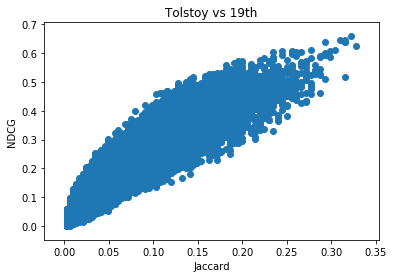

In [120]:
plt.scatter(Real_shifts['T19_Jaccard'], Real_shifts['T19_NDCG'])
plt.title('Tolstoy vs 19th')
plt.ylabel('NDCG')
plt.xlabel('Jaccard')

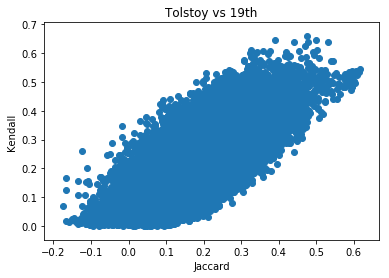

In [121]:
plt.scatter(Real_shifts['T19_Kendall'], Real_shifts['T19_NDCG'])
plt.title('Tolstoy vs 19th')
plt.ylabel('Kendall')
plt.xlabel('Jaccard')

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [123]:
Real_shifts = Real_shifts.dropna()

In [132]:
AS[['19_Kendall','19_Jaccard','19_NDCG']].shape

(596, 3)

In [136]:
X_train = AS[['T_Kendall','T_Kendall','T_NDCG']]
poly = PolynomialFeatures(4)
X_train = poly.fit_transform(X_train)
Y = AS['Q']

X_real = poly.transform(AS[['19_Kendall','19_Jaccard','19_NDCG']])

lr = LinearRegression()
lr.fit(X_train, Y)

AS['X'] = lr.predict(X_real)
data = AS[['Q', 'X']]
data.corr(method='pearson')

,Q,X
Q,1.000000,0.477292
X,0.477292,1.000000


** Толстой vs 19 век **

In [137]:
X_real = poly.transform(Real_shifts[['T19_Kendall','T19_Jaccard','T19_NDCG']])

lr = LinearRegression()
lr.fit(X_train, Y)

Real_shifts['T19_LR'] = lr.predict(X_real)

In [138]:
X_real = poly.transform(Real_shifts[['TA_Kendall','TA_Jaccard','TA_NDCG']])

lr = LinearRegression()
lr.fit(X_train, Y)

Real_shifts['TA_LR'] = lr.predict(X_real)

In [139]:
X_real = poly.transform(Real_shifts[['19A_Kendall','19A_Jaccard','19A_NDCG']])

lr = LinearRegression()
lr.fit(X_train, Y)

Real_shifts['19A_LR'] = lr.predict(X_real)

In [140]:
X_train = AS[['19_Kendall','19_Kendall','19_NDCG']]
poly = PolynomialFeatures(4)
X_train = poly.fit_transform(X_train)
Y = AS['Q']

X_real = poly.transform(Real_shifts[['19A_Kendall','19A_Jaccard','19A_NDCG']])

lr = LinearRegression()
lr.fit(X_train, Y)

Real_shifts['19A_LR_19'] = lr.predict(X_real)

In [150]:
data = Real_shifts[['Lemma','TA','T19','19A','TA_LR','T19_LR','19A_LR','19A_LR_19']]
data.corr(method='pearson')

,TA,T19,19A,TA_LR,T19_LR,19A_LR,19A_LR_19
TA,1.000000,0.518380,0.687035,-0.080589,-0.039984,0.088974,0.141358
T19,0.518380,1.000000,0.281401,-0.095562,-0.124273,-0.004306,0.098537
19A,0.687035,0.281401,1.000000,-0.041258,0.006401,-0.007167,0.436865
TA_LR,-0.080589,-0.095562,-0.041258,1.000000,0.231298,0.107051,-0.016960
T19_LR,-0.039984,-0.124273,0.006401,0.231298,1.000000,0.002077,0.019715
19A_LR,0.088974,-0.004306,-0.007167,0.107051,0.002077,1.000000,-0.469091
19A_LR_19,0.141358,0.098537,0.436865,-0.016960,0.019715,-0.469091,1.000000


In [151]:
data.corr(method='kendall')

,TA,T19,19A,TA_LR,T19_LR,19A_LR,19A_LR_19
TA,1.000000,0.432735,0.455668,0.012271,-0.021656,-0.031627,0.235395
T19,0.432735,1.000000,0.155943,-0.027552,-0.119497,-0.009734,0.077795
19A,0.455668,0.155943,1.000000,0.035993,0.012312,-0.092102,0.471772
TA_LR,0.012271,-0.027552,0.035993,1.000000,0.107430,0.070425,0.046582
T19_LR,-0.021656,-0.119497,0.012312,0.107430,1.000000,0.003538,0.006819
19A_LR,-0.031627,-0.009734,-0.092102,0.070425,0.003538,1.000000,-0.103286
19A_LR_19,0.235395,0.077795,0.471772,0.046582,0.006819,-0.103286,1.000000


In [152]:
data.corr(method='spearman')

,TA,T19,19A,TA_LR,T19_LR,19A_LR,19A_LR_19
TA,1.000000,0.607742,0.629021,0.016931,-0.027006,-0.041520,0.345993
T19,0.607742,1.000000,0.230029,-0.038884,-0.136456,-0.014391,0.115864
19A,0.629021,0.230029,1.000000,0.054958,0.018867,-0.086841,0.609175
TA_LR,0.016931,-0.038884,0.054958,1.000000,0.158270,0.103109,0.072714
T19_LR,-0.027006,-0.136456,0.018867,0.158270,1.000000,0.005022,0.010303
19A_LR,-0.041520,-0.014391,-0.086841,0.103109,0.005022,1.000000,-0.110807
19A_LR_19,0.345993,0.115864,0.609175,0.072714,0.010303,-0.110807,1.000000


In [142]:
stat = data.describe()
stat.round(6)

,TA,T19,19A,TA_LR,T19_LR,19A_LR,19A_LR_19
count,21601.000000,21601.000000,21601.000000,21601.000000,21601.000000,21601.000000,21601.000000
mean,0.004088,0.024181,0.022422,0.632315,0.624662,0.625622,0.605765
std,0.008744,0.024830,0.027398,0.036161,0.017836,0.021598,0.026113
min,0.000000,0.000001,0.000000,0.566526,0.569729,0.566622,-0.259139
25%,0.000224,0.005913,0.003905,0.611521,0.617932,0.617218,0.596395
50%,0.001155,0.016188,0.012773,0.622594,0.621124,0.620773,0.604057
75%,0.004166,0.034597,0.031239,0.641908,0.625959,0.627056,0.615118
max,0.138495,0.211792,0.284435,0.956397,0.902489,0.926057,0.712664


In [143]:
data = data.set_index('Lemma')

In [144]:
data.head()

,TA,T19,19A,TA_LR,T19_LR,19A_LR,19A_LR_19
Lemma,,,,,,,
евангелие,0.038761,0.043543,0.071645,0.616531,0.615257,0.622381,0.640498
откровение,0.007981,0.043951,0.004827,0.621548,0.615702,0.616951,0.602963
истинный,0.004176,0.013778,0.009525,0.616388,0.625075,0.621493,0.601005
благо,0.016426,0.053191,0.055370,0.610576,0.621171,0.619394,0.626867
иисус,0.038315,0.039585,0.049181,0.617373,0.616618,0.620218,0.612511


In [157]:
Real_shifts.to_csv('./data/Real_shifts.csv', sep='\t', index=False, encoding='utf-8')

In [57]:
print (NKRYA_FT_SG.wv.most_similar('защитник'), '\n\n', Araneum_FT_SG.wv.most_similar('защитник'))

[('защитница', 0.8308982849121094), ('защита', 0.6954416036605835), ('сторонник', 0.5907248258590698), ('обвинитель', 0.5799415111541748), ('охранитель', 0.5718965530395508), ('гонитель', 0.5585989952087402), ('защитительный', 0.5306378602981567), ('защищать', 0.5260261297225952), ('защищение', 0.5246472358703613), ('представитель', 0.5181863903999329)] 

 [('отечество', 0.6177961826324463), ('защитница', 0.6004931926727295), ('нападающий', 0.5983943939208984), ('оборонец', 0.5920811891555786), ('воин', 0.5654779076576233), ('полузащитник', 0.5624524354934692), ('голкипер', 0.5511013865470886), ('вингер', 0.5471912622451782), ('заступник', 0.544640064239502), ('сосновоборец', 0.5405257940292358)]


## Качественная оценка результатов

In [7]:
Tolstoy_FT_SG = gensim.models.fasttext.FastText.load("./models/Tolstoy_FT_SG.model")
NKRYA_FT_SG = gensim.models.fasttext.FastText.load("./models/NKRYA_FT_SG.model")
Araneum_FT_SG = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextskipgram_300_5_2018.model")

In [9]:
Real_shifts = pd.read_csv('./data/Real_shifts2.csv', sep='\t')

In [59]:
def get_POS(word):
    try:
        p = morph.parse(word)[0]
        return p.tag.POS
    except:
        return '?'

In [60]:
POS_vec = np.vectorize(get_POS)

In [12]:
Real_shifts['POS'] = POS_vec(Real_shifts['Lemma'].values)

In [13]:
Real_shifts = Real_shifts[['Lemma', 'POS','TA','T19','19A']]

In [19]:
Real_shifts = Real_shifts.sort_values(by=['TA'])

In [21]:
Real_shifts.shape[0]

21601

In [24]:
Real_shifts.head()

,Lemma,POS,TA,T19,19A
18943,рифма,NOUN,1.861103e-07,0.001595,0.025159
10852,франклин,NOUN,1.906489e-07,0.005126,0.000093
18030,недостроенный,ADJF,1.909409e-07,0.006246,0.013136
3580,азовский,ADJF,1.998292e-07,0.007380,0.000383
15893,регалия,NOUN,2.006394e-07,0.001510,0.002967


In [46]:
tags = ['NOUN','ADJF','ADJS','INFN','PRTF','NUMR','ADVB','NPRO','PREP','CONJ','PRCL','INTJ']

In [102]:
for i in tags:
    print ('{}\t{}\t{}'.format(i, 
                              Real_shifts[Real_shifts.POS==i].shape[0], 
                              Real_shifts[Real_shifts.POS==i]['TA'].mean()))

NOUN	9553	0.003594277223228845
ADJF	3990	0.0036080874954352304
ADJS	125	0.006139648374034462
INFN	6222	0.004676791995807615
PRTF	174	0.0025089190018681966
NUMR	42	0.0689837025995985
ADVB	1198	0.004755195142797608
NPRO	15	0.004984781944888403
PREP	41	0.001394876210705772
CONJ	52	0.003129475254353596
PRCL	19	0.0010954368708504304
INTJ	32	0.001118160480125973


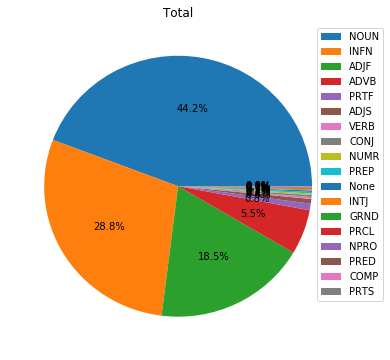

In [133]:
X = Real_shifts['POS'].value_counts()
plt.figure(figsize=(6,6))
labels = X.index
plt.pie(X, labels = None, autopct='%1.1f%%')
plt.legend(labels, bbox_to_anchor=(0.9,1))
plt.title('Total')
plt.savefig('Total.png', dpi=200)
plt.show()

In [80]:
HEAD = Real_shifts.head(1000)

In [81]:
HEAD['POS'].value_counts().index

Index(['NOUN', 'ADJF', 'INFN', 'ADVB', 'None', 'ADJS', 'PRTF', 'VERB', 'PREP',
       'CONJ', 'INTJ', 'GRND'],
      dtype='object')

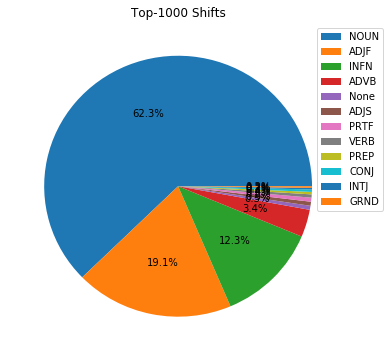

In [134]:
plt.figure(figsize=(6,6))
labels = HEAD['POS'].value_counts().index
plt.pie(HEAD['POS'].value_counts(), labels = None, autopct='%1.1f%%')
plt.legend(labels, bbox_to_anchor=(0.9,1))
plt.title('Top-1000 Shifts')
plt.savefig('Head_1000_POS.png', dpi=200)
plt.show()

In [92]:
TAIL = Real_shifts.tail(1000)

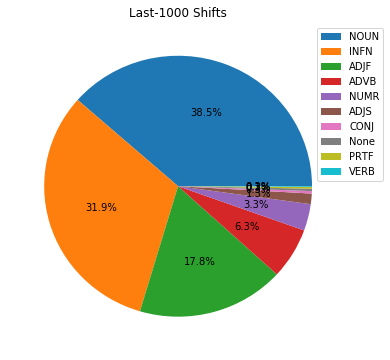

In [136]:
plt.figure(figsize=(6,6))
labels = TAIL['POS'].value_counts().index
plt.pie(TAIL['POS'].value_counts(), labels = None, autopct='%1.1f%%')
plt.legend(labels, bbox_to_anchor=(0.9,1))
plt.title('Last-1000 Shifts')
plt.savefig('TAIL_1000_POS.png', dpi=200)
plt.show()

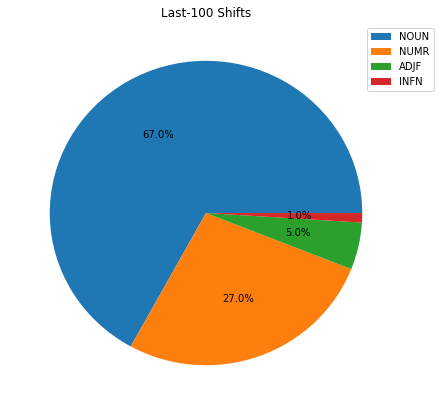

In [141]:
T50 = Real_shifts.tail(100)

plt.figure(figsize=(7,7))
labels = T50['POS'].value_counts().index
plt.pie(T50['POS'].value_counts(), labels = None, autopct='%1.1f%%')
plt.legend(labels, bbox_to_anchor=(0.9,1))
plt.title('Last-100 Shifts')
plt.savefig('TAIL_100_POS.png', dpi=200)
plt.show()

In [29]:
Real_shifts[Real_shifts.POS=='CONJ']['TA'].mean()

0.003129475254353596

In [175]:
data = Real_shifts[['Lemma','TA']]
data = data.set_index('Lemma')

In [176]:
list_43 = pd.read_csv('./data/43.txt', sep='\t')
list_43 = list_43.set_index('word')
check = pd.concat([list_43, data], axis=1, join='inner')
check.to_csv('./data/check43.csv', sep='\t', index=False, encoding='utf-8')

In [177]:
check.sort_values(by=['TA'])

,TA
привет,0.000001
элемент,0.000014
управа,0.000018
участок,0.000021
защитник,0.000023
декрет,0.000028
отделение,0.000034
казенный,0.000080
отдел,0.000081
особа,0.000092


In [164]:
def top_similar(word, n=10):
    a = list(zip(*Tolstoy_FT_SG.wv.most_similar(word, topn=n)))[0]
    print ('Толстой: ',', '.join(a))
    print()
    b = list(zip(*Araneum_FT_SG.wv.most_similar(word, topn=n)))[0]
    print ('Araneum: ',', '.join(b))

In [59]:
def top(word, n=10):
    t = list(zip(*Tolstoy_FT_SG.wv.most_similar(word, topn=n)))[0]
    print ('Толстой FT: ',', '.join(t))
    print()
    t2 = list(zip(*Tolstoy_W2V_SG.wv.most_similar(word, topn=n)))[0]
    print ('Толстой W2V: ',', '.join(t2))
    print()
    a = list(zip(*NKRYA_FT_SG.wv.most_similar(word, topn=n)))[0]
    print ('19 век: ',', '.join(a))
    print()
    b = list(zip(*Araneum_FT_SG.wv.most_similar(word, topn=n)))[0]
    print ('Araneum: ',', '.join(b))

In [63]:
top('участок', n=20)

Толстой FT:  участница, участник, участь, участие, частокол, соучастник, соучастие, участвующий, участвовать, безучастный, учащий, безучастно, тюк, неучастие, стокгольм, заем, бенарес, тюремщик, убыток, участливый

Толстой W2V:  пензенский, зажиточный, волость, округ, угодье, псковский, курский, чернский, селение, излегощь, бузулукский, попечитель, аренда, вотчина, владетель, выборный, поселять, родовой, выселять, управа

19 век:  участковый, счасток, община-волость, частокол, волость, крестьянин-собственник, сток, арендование, округ, заселение, десятина, малоземельный, пахотный, усадебный, размежевание, судохозяин, надел, земельный, заводоуправление, селение

Araneum:  земельный, ижс, сотка, надел, промназначение, участочек, сельхозназначение, снт, незастроенный, землепользователь, дачный, домовладение, межевание, сельхозугодье, размежевывать, приусадебный, днт, зем, придомовый, сельхозугодие


In [202]:
top_similar('гулящий', 15)

Толстой:  палящий, курящий, спящий, горящий, некурящий, бодрящий, болящий, седящий, лядащий, вещий, звенящий, тощий, свистящий, говорящий, лакированный

Araneum:  женка, беспутный, молодуха, распутный, завалящий, гуляка, загуливать, гулена, пьяница, девка, мужененавистница, мужний, бобыль, работящий, блудить


In [149]:
print (list(zip(*Tolstoy_FT_SG.wv.most_similar('защитник')))[0], '\n\n', list(zip(*Araneum_FT_SG.wv.most_similar('защитник')))[0])

('союзник', 'защита', 'кляузник', 'путник', 'беззаконник', 'беззащитный', 'завоеватель', 'финик', 'обвинитель', 'угнетатель') 

 ('отечество', 'защитница', 'нападающий', 'оборонец', 'воин', 'полузащитник', 'голкипер', 'вингер', 'заступник', 'сосновоборец')


## Сравнение с 19 веком

In [50]:
Real_shifts = Real_shifts.sort_values(by=['T19'])
Real_shifts.head()

,Lemma,POS,TA,T19,19A
16714,синдикат,NOUN,0.000045,7.700994e-07,0.000045
8839,метаморфоза,NOUN,0.000015,1.114373e-06,0.000690
8277,анекдот,NOUN,0.000022,1.265652e-06,0.037857
6527,намедни,ADVB,0.000014,2.084619e-06,0.000935
18173,тормоз,NOUN,0.000100,3.103306e-06,0.000826


In [49]:
tags = ['NOUN','ADJF','ADJS','INFN','PRTF','NUMR',
        'ADVB','NPRO','PREP','CONJ','PRCL','INTJ']
for i in tags:
    print ('{}\t{}\t{}'.format(i, 
                              Real_shifts[Real_shifts.POS==i].shape[0], 
                              Real_shifts[Real_shifts.POS==i]['T19'].mean()))

NOUN	9553	0.019001010585644452
ADJF	3990	0.024770578902732373
ADJS	125	0.02278108515311122
INFN	6222	0.032071652780885786
PRTF	174	0.024087411341412953
NUMR	42	0.11439637899080674
ADVB	1198	0.022927262227365058
NPRO	15	0.0157184159049272
PREP	41	0.011826287694128558
CONJ	52	0.01127321476887259
PRCL	19	0.007280719254024611
INTJ	32	0.006201505274895392


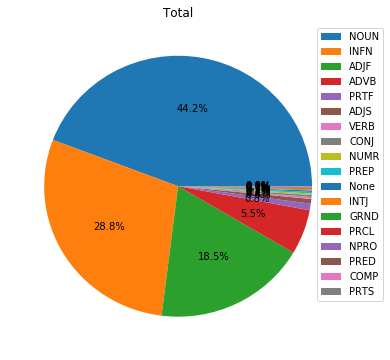

In [51]:
X = Real_shifts['POS'].value_counts()
plt.figure(figsize=(6,6))
labels = X.index
plt.pie(X, labels = None, autopct='%1.1f%%')
plt.legend(labels, bbox_to_anchor=(0.9,1))
plt.title('Total')
plt.savefig('Total.png', dpi=200)
plt.show()

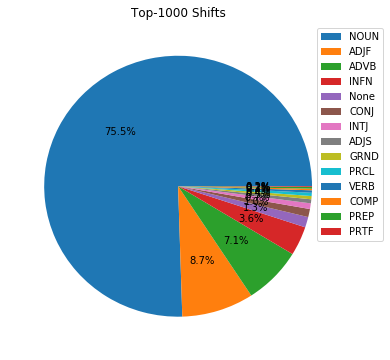

In [52]:
HEAD = Real_shifts.head(1000)
plt.figure(figsize=(6,6))
labels = HEAD['POS'].value_counts().index
plt.pie(HEAD['POS'].value_counts(), labels = None, autopct='%1.1f%%')
plt.legend(labels, bbox_to_anchor=(0.9,1))
plt.title('Top-1000 Shifts')
plt.savefig('Head_1000_POS.png', dpi=200)
plt.show()

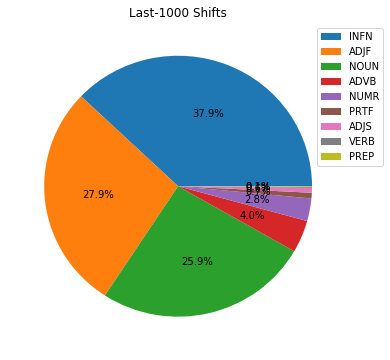

In [19]:
TAIL = Real_shifts.tail(1000)
plt.figure(figsize=(6,6))
labels = TAIL['POS'].value_counts().index
plt.pie(TAIL['POS'].value_counts(), labels = None, autopct='%1.1f%%')
plt.legend(labels, bbox_to_anchor=(0.9,1))
plt.title('Last-1000 Shifts')
plt.savefig('TAIL_1000_POS.png', dpi=200)
plt.show()

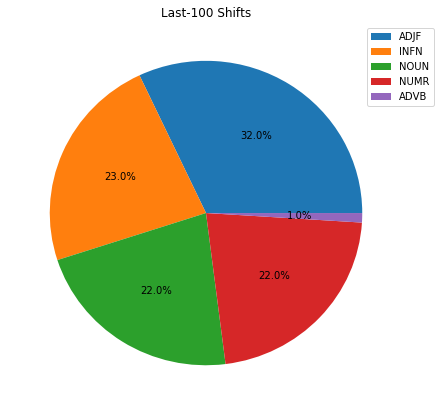

In [20]:
T50 = Real_shifts.tail(100)

plt.figure(figsize=(7,7))
labels = T50['POS'].value_counts().index
plt.pie(T50['POS'].value_counts(), labels = None, autopct='%1.1f%%')
plt.legend(labels, bbox_to_anchor=(0.9,1))
plt.title('Last-100 Shifts')
plt.savefig('TAIL_100_POS.png', dpi=200)
plt.show()

In [22]:
data = Real_shifts[['Lemma','T19']]
data = data.set_index('Lemma')

list_43 = pd.read_csv('./data/43.txt', sep='\t')
list_43 = list_43.set_index('word')
check = pd.concat([list_43, data], axis=1, join='inner')
check.to_csv('./data/check43.csv', sep='\t', index=False, encoding='utf-8')

check.sort_values(by=['T19'])

In [24]:
def top(word, n=10):
    t = list(zip(*Tolstoy_FT_SG.wv.most_similar(word, topn=n)))[0]
    print ('Толстой FT: ',', '.join(t))
    print()
    t2 = list(zip(*Tolstoy_W2V_SG.wv.most_similar(word, topn=n)))[0]
    print ('Толстой W2V: ',', '.join(t2))
    print()
    a = list(zip(*NKRYA_FT_SG.wv.most_similar(word, topn=n)))[0]
    print ('19 век: ',', '.join(a))

In [28]:
Real_shifts.head(30)

,Lemma,POS,TA,T19,19A
16714,синдикат,NOUN,0.000045,7.700994e-07,0.000045
8839,метаморфоза,NOUN,0.000015,1.114373e-06,0.000690
8277,анекдот,NOUN,0.000022,1.265652e-06,0.037857
6527,намедни,ADVB,0.000014,2.084619e-06,0.000935
18173,тормоз,NOUN,0.000100,3.103306e-06,0.000826
11112,моряк,NOUN,0.000005,3.469688e-06,0.033063
20349,песталоцци,NOUN,0.000048,3.540764e-06,0.004451
18709,фаэтон,NOUN,0.000032,3.859341e-06,0.004104
2452,наилучше,COMP,0.000096,5.089167e-06,0.000048
12215,жук,NOUN,0.000055,5.396562e-06,0.014630


In [29]:
Real_shifts.tail(30)

,Lemma,POS,TA,T19,19A
20814,мнительность,NOUN,0.002571,0.151684,0.007212
20246,питательность,NOUN,0.000031,0.152481,0.000138
6806,схватываться,INFN,0.014095,0.152726,0.026317
3767,сорок,NUMR,0.091636,0.153389,0.133051
7946,десятка,NOUN,0.019844,0.153600,0.027744
16399,бездеятельность,NOUN,0.001123,0.153646,0.005689
1666,десяток,NOUN,0.078938,0.153701,0.117747
7483,переписывать,INFN,0.020501,0.154677,0.039507
2155,действительность,NOUN,0.000366,0.155213,0.000983
4363,хлопнуть,INFN,0.033650,0.156704,0.098698


In [26]:
Tolstoy_W2V_SG = gensim.models.Word2Vec.load("./models/Tolstoy_W2V_SG.model")

In [53]:
top('защитник')

Толстой FT:  союзник, защита, кляузник, путник, беззаконник, беззащитный, завоеватель, финик, обвинитель, угнетатель

Толстой W2V:  победоносный, консерватор, веротерпимость, консервативный, беззаконный, протестовать, узаконивать, полководец, безбожный, конституционный

19 век:  защитница, защита, сторонник, обвинитель, охранитель, гонитель, защитительный, защищать, защищение, представитель


In [64]:
top('грудь',20)

Толстой FT:  грудка, груздь, груда, гибко, лоб, мускул, локоть, муфта, шея, чубук, мускулистый, мышца, пухлый, ноздря, плечико, жолудь, шнурок, плечики, костлявый, спина

Толстой W2V:  спина, кисть, ладонь, указательный, подбородок, костлявый, локоть, обнаженный, выпрямлять, мышца, перышко, сгибать, мизинец, раскачивать, прижимать, жила, сжимать, повисать, шея, скула

19 век:  грудь-то, грудка, спина, висок, бедро, шея, плечико, плечики, желудь, судорожно, затылок, темя, плечо, локоток, плечи, навылет, живот, сердце, ляжка, горло

Araneum:  живот, сосок, ягодица, животик, бедро, шея, подбородок, грудной, талия, ключица, спина, пах, торс, подмышка, предплечье, промежность, пупок, бюстгалтер, поясница, ляжка


## Исправления

In [5]:
sentences_tolstoy = gensim.models.word2vec.LineSentence('full_collection.txt')
sentences_nkrya = gensim.models.word2vec.LineSentence('nkrya.txt')

In [9]:
Tolstoy_FT_SG = gensim.models.fasttext.FastText(sentences_tolstoy, 
                                            min_count=100, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
Tolstoy_FT_SG.save("./final/Tolstoy_FT_SG.model")
print(Tolstoy_FT_SG)

FastText(vocab=3452, size=300, alpha=0.025)


In [6]:
NKRYA_FT_SG = gensim.models.fasttext.FastText(sentences_nkrya, 
                                            min_count=100, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
NKRYA_FT_SG.save("./final/NKRYA_FT_SG.model")
print(NKRYA_FT_SG)

FastText(vocab=18254, size=300, alpha=0.025)


In [7]:
Tolstoy_W2V_SG = gensim.models.Word2Vec(sentences_tolstoy, 
                                            min_count=100, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
Tolstoy_W2V_SG.save("./final/Tolstoy_W2V_SG.model")
print(Tolstoy_W2V_SG)

Word2Vec(vocab=3452, size=300, alpha=0.025)


In [8]:
NKRYA_W2V_SG = gensim.models.Word2Vec(sentences_nkrya, 
                                            min_count=100, sorted_vocab=1, 
                                            size=300, window = 5, sg=1, 
                                            seed=23) #Skipgram
NKRYA_W2V_SG.save("./final/NKRYA_W2V_SG.model")
print(NKRYA_W2V_SG)

Word2Vec(vocab=18254, size=300, alpha=0.025)


In [8]:
Tolstoy_W2V_SG = gensim.models.Word2Vec.load("./final/Tolstoy_W2V_SG.model")
NKRYA_W2V_SG = gensim.models.Word2Vec.load("./final/NKRYA_W2V_SG.model")
Tolstoy_FT_SG = gensim.models.fasttext.FastText.load("./final/Tolstoy_FT_SG.model")
NKRYA_FT_SG = gensim.models.fasttext.FastText.load("./final/NKRYA_FT_SG.model")

In [9]:
Araneum_FT_SG = gensim.models.fasttext.FastText.load("./models/araneum_none_fasttextskipgram_300_5_2018.model")

In [10]:
vocab = Tolstoy_W2V_SG.wv.vocab.keys()

In [11]:
Real_shifts = pd.DataFrame({'Lemma':list(vocab)})

In [18]:
Real_shifts['T19_Kendall_w2v'] = Kendall_vec(Real_shifts['Lemma'].values, Tolstoy_W2V_SG, NKRYA_W2V_SG, 150)
Real_shifts['T19_Jaccard_w2v'] = Jaccard_vec(Real_shifts['Lemma'].values, Tolstoy_W2V_SG, NKRYA_W2V_SG, 150)
Real_shifts['T19_NDCG_w2v'] = ndcg_vec(Real_shifts['Lemma'].values, Tolstoy_W2V_SG, NKRYA_W2V_SG, 150)
Real_shifts['T19_w2v'] = Real_shifts['T19_Jaccard_w2v'].values*Real_shifts['T19_NDCG_w2v'].values
Real_shifts['T19_Kendall_ft'] = Kendall_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG, 150)
Real_shifts['T19_Jaccard_ft'] = Jaccard_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG, 150)
Real_shifts['T19_NDCG_ft'] = ndcg_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, NKRYA_FT_SG, 150)
Real_shifts['T19_ft'] = Real_shifts['T19_Jaccard_ft'].values*Real_shifts['T19_NDCG_ft'].values

In [19]:
Real_shifts['TA_Kendall_ft'] = Kendall_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, Araneum_FT_SG, 150)
Real_shifts['TA_Jaccard_ft'] = Jaccard_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, Araneum_FT_SG, 150)
Real_shifts['TA_NDCG_ft'] = ndcg_vec(Real_shifts['Lemma'].values, Tolstoy_FT_SG, Araneum_FT_SG, 150)
Real_shifts['TA_ft'] = Real_shifts['TA_Jaccard_ft'].values*Real_shifts['TA_NDCG_ft'].values

In [22]:
Real_shifts = Real_shifts.dropna()

In [29]:
Real_shifts.to_csv('./result_all.csv', sep='\t', index=False, encoding='utf-8')

In [34]:
data = Real_shifts[['Lemma','T19_w2v','T19_ft', 'TA_ft']]

In [35]:
data.to_csv('./result_short.csv', sep='\t', index=False, encoding='utf-8')

In [41]:
data.corr(method='pearson')

,T19_w2v,T19_ft,TA_ft
T19_w2v,1.000000,0.839271,0.644963
T19_ft,0.839271,1.000000,0.637474
TA_ft,0.644963,0.637474,1.000000


In [43]:
data.sort_values(by=['T19_ft']).head(10)

,Lemma,T19_w2v,T19_ft,TA_ft
3320,замерзать,0.002681,0.000030,0.000271
494,покрывать,0.002049,0.000180,0.000071
3449,чертков,0.000529,0.000185,0.000036
643,материя,0.000639,0.000263,0.000196
3221,запутываться,0.000176,0.000311,0.000050
2329,крупный,0.001224,0.000403,0.000045
1949,портрет,0.001468,0.000430,0.000041
3083,некогда,0.000488,0.000463,0.000029
2120,платон,0.002394,0.000509,0.000246
72,соль,0.000546,0.000541,0.000031


In [39]:
data.describe()

,T19_w2v,T19_ft,TA_ft
count,3160.000000,3160.000000,3160.000000
mean,0.021173,0.024160,0.005349
std,0.016686,0.016874,0.006620
min,0.000030,0.000030,0.000002
25%,0.008851,0.011480,0.000923
50%,0.016895,0.020602,0.002809
75%,0.029218,0.032664,0.007420
max,0.141177,0.114869,0.046858


In [45]:
data.shape

(3160, 4)

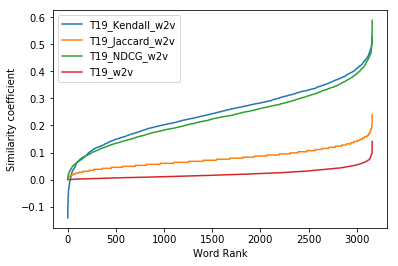

In [52]:
plt.plot(list(range(3160)), list(sorted(Real_shifts['T19_Kendall_w2v'])), label = 'T19_Kendall_w2v')
plt.plot(list(range(3160)), list(sorted(Real_shifts['T19_Jaccard_w2v'])), label = 'T19_Jaccard_w2v')
plt.plot(list(range(3160)), list(sorted(Real_shifts['T19_NDCG_w2v'])), label = 'T19_NDCG_w2v')
plt.plot(list(range(3160)), list(sorted(Real_shifts['T19_w2v'])), label = 'T19_w2v')
plt.legend(['T19_Kendall_w2v', 'T19_Jaccard_w2v','T19_NDCG_w2v','T19_w2v'])
plt.ylabel('Similarity coefficient')
plt.xlabel('Word Rank')
#plt.savefig('Similarity.png', dpi=200)
plt.show()

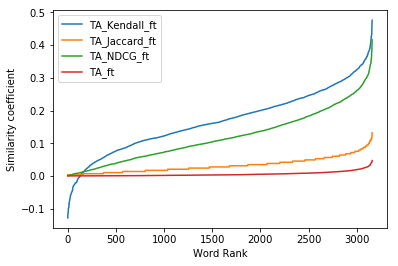

In [54]:
plt.plot(list(range(3160)), list(sorted(Real_shifts['TA_Kendall_ft'])), label = 'TA_Kendall_ft')
plt.plot(list(range(3160)), list(sorted(Real_shifts['TA_Jaccard_ft'])), label = 'TA_Jaccard_ft')
plt.plot(list(range(3160)), list(sorted(Real_shifts['TA_NDCG_ft'])), label = 'TA_NDCG_ft')
plt.plot(list(range(3160)), list(sorted(Real_shifts['TA_ft'])), label = 'TA_ft')
plt.legend(['TA_Kendall_ft', 'TA_Jaccard_ft','TA_NDCG_ft','TA_ft'])
plt.ylabel('Similarity coefficient')
plt.xlabel('Word Rank')
#plt.savefig('Similarity.png', dpi=200)
plt.show()

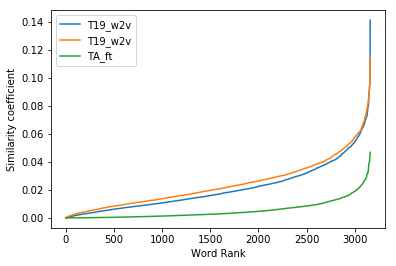

In [49]:
plt.plot(list(range(3160)), list(sorted(data['T19_w2v'])), label = 'T19_w2v')
plt.plot(list(range(3160)), list(sorted(data['T19_ft'])), label = 'T19_w2v')
plt.plot(list(range(3160)), list(sorted(data['TA_ft'])), label = 'TA_ft')
plt.legend(['T19_w2v', 'T19_w2v','TA_ft'])
plt.ylabel('Similarity coefficient')
plt.xlabel('Word Rank')
plt.savefig('Similarity.png', dpi=200)
plt.show()

In [57]:
data2 = Real_shifts[['Lemma','TA_ft']]
data2 = data2.set_index('Lemma')

list_43 = pd.read_csv('./data/43.txt', sep='\t')
list_43 = list_43.set_index('word')
check = pd.concat([list_43, data2], axis=1, join='inner')
check.to_csv('./data/check43.csv', sep='\t', index=False, encoding='utf-8')

check.sort_values(by=['TA_ft'])

,TA_ft
машина,0.000008
отделение,0.000029
чиновник,0.000069
тройка,0.000154
отдел,0.000178
молодец,0.000275
палата,0.000503
привет,0.000520
публика,0.000658
управление,0.000875


In [58]:
data2 = Real_shifts[['Lemma','T19_ft']]
data2 = data2.set_index('Lemma')

list_43 = pd.read_csv('./data/43.txt', sep='\t')
list_43 = list_43.set_index('word')
check = pd.concat([list_43, data2], axis=1, join='inner')
check.to_csv('./data/check43.csv', sep='\t', index=False, encoding='utf-8')

check.sort_values(by=['T19_ft'])

,T19_ft
машина,0.007351
молодец,0.008511
смотритель,0.009089
присутствие,0.010248
привет,0.011759
публика,0.012102
отделение,0.016828
чиновник,0.021069
тройка,0.022256
отдел,0.026573


In [55]:
def top(word, n=10):
    t = list(zip(*Tolstoy_FT_SG.wv.most_similar(word, topn=n)))[0]
    print ('Толстой FT: ',', '.join(t))
    print()
    a = list(zip(*NKRYA_FT_SG.wv.most_similar(word, topn=n)))[0]
    print ('19 век: ',', '.join(a))
    print()
    b = list(zip(*Araneum_FT_SG.wv.most_similar(word, topn=n)))[0]
    print ('Araneum: ',', '.join(b))

In [198]:
top('уверенный', 20)

Толстой FT:  уверенность, уверять, убежденный, убеждать, убеждаться, надеяться, сомневаться, поверять, соглашаться, предполагать, ошибаться, казаться, блаженный, довольный, раскаиваться, удаваться, несомненный, верить, согласный, наверное

19 век:  убежденный, уверенно, уверять, уверенность, уверяться, уверение, уверовать, самоуверенный, надеяться, убеждать, разуверять, поверенный, убеждаться, заверять, верить, намеренный, довольный, поверять, доверенный, сомневаться

Araneum:  уверять, сомневаться, убежденный, думать, уверенность, поручиться, убеждать, поверять, увереный, уверяться, вряд, ручаться, надеяться, верить, знать, сказать, навряд, наверняка, засомневаться, считать


In [62]:
data['POS'] = POS_vec(data['Lemma'].values)

In [63]:
data.head()

,Lemma,T19_w2v,T19_ft,TA_ft,POS
0,евангелие,0.059775,0.074483,0.026531,NOUN
2,откровение,0.038386,0.021336,0.011646,NOUN
3,истинный,0.055156,0.042000,0.010603,ADJF
4,благо,0.056284,0.045146,0.001943,CONJ
5,иисус,0.030091,0.031713,0.028763,NOUN


In [118]:
pos = pd.DataFrame({'POS':data['POS'].value_counts().values})

In [125]:
a = data['POS'].value_counts()/data.shape[0]
pos['Total'] = a.values

In [120]:
def get_values(a, b):
    by = []
    for i in a.index:
        if i in b:
            by.append(b[i])
        else:
            by.append(0)
    return by

In [138]:
pos['TA_ft_first_1000'] = get_values(a, data.sort_values(by=['TA_ft'])[:1000]['POS'].value_counts()/1000)
pos['T19_ft_first_1000'] = get_values(a, data.sort_values(by=['T19_ft'])[:1000]['POS'].value_counts()/1000)
pos['TA_ft_last_1000'] = get_values(a, data.sort_values(by=['TA_ft'])[-1000:]['POS'].value_counts()/1000)
pos['T19_ft_last_1000'] = get_values(a, data.sort_values(by=['T19_ft'])[-1000:]['POS'].value_counts()/1000)

In [139]:
pos['TA_ft_last_1000'].sum()

1.0

In [129]:
del pos['POS']

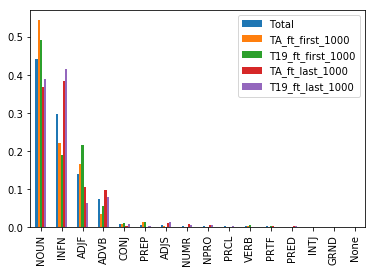

In [149]:
pos.plot.bar()
plt.xticks(x, xticks, rotation='vertical')
plt.show()

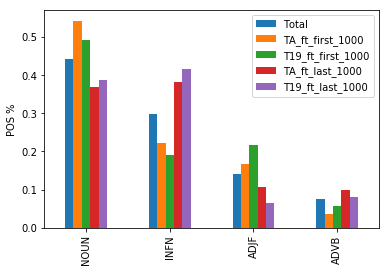

In [202]:
plt.figure(figsize=(6,6))
pos[:4].plot.bar()
plt.xticks(x[:4], xticks[:4], rotation='vertical')
plt.savefig('Firstly-last.png', dpi=400)
plt.ylabel('POS %')
plt.show()

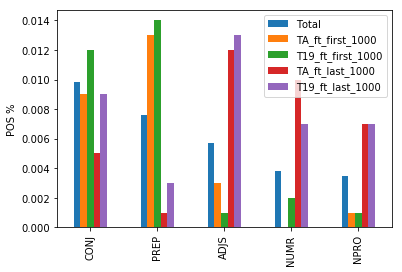

In [200]:
pos[4:9].plot.bar()
c = xticks[4:9]
plt.xticks(x[:5], c, rotation='vertical')
plt.savefig('Firstly-last2.png', dpi=200)
plt.ylabel('POS %')
plt.show()